# Importación de módulos

In [155]:
import pandas as pd
import numpy as np
import seaborn as sn
import plotly.express as px
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display

# Formateo de outputs en Jupyter

In [156]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format

# Importación de datos

In [157]:
data_df = pd.read_csv('synchronous_machine.csv')
data_df

,Iy,PF,e,dIf,If
0,3.000,0.660,0.340,0.383,1.563
1,3.000,0.680,0.320,0.372,1.552
2,3.000,0.700,0.300,0.360,1.540
3,3.000,0.720,0.280,0.338,1.518
4,3.000,0.740,0.260,0.317,1.497
...,...,...,...,...,...
552,6.000,0.910,0.090,0.142,1.322
553,6.000,0.930,0.070,0.151,1.331
554,6.000,0.950,0.050,0.160,1.340
555,6.000,0.970,0.030,0.160,1.340


# Análisis de los datos

In [158]:
display(data_df.describe())#da mean, std, min, cuantiles 25,50,75%, max
display(data_df.isna().sum())#dice si hay valores en blanco o no numericos

figIy = px.box(data_df, y='Iy')
figIy.show()
figPF = px.box(data_df, y='PF')
figPF.show()
fige = px.box(data_df, y='e')
fige.show()
figdIf = px.box(data_df, y='dIf')
figdIf.show()
figIf = px.box(data_df, y='If')
figIf.show()

def IQR_outlier(data_df):
    q1 = data_df.quantile(0.25)
    q3 = data_df.quantile(0.75)
    
    IQR = q3-q1
    
    print("Lower ceiling:\n", q1-1.5*IQR)
    print("Upper ceiling:\n", q3+1.5*IQR)
    
    outliers = data_df[((data_df<(q1-1.5*IQR)) | (data_df>(q3+1.5*IQR)))]

    return outliers

print(IQR_outlier(data_df))

,Iy,PF,e,dIf,If
count,557.000,557.000,557.000,557.000,557.000
mean,4.500,0.825,0.175,0.351,1.531
std,0.896,0.104,0.104,0.181,0.181
min,3.000,0.650,0.000,0.037,1.217
25%,3.700,0.740,0.080,0.189,1.369
50%,4.500,0.820,0.180,0.345,1.525
75%,5.300,0.920,0.260,0.486,1.666
max,6.000,1.000,0.350,0.769,1.949


Iy     0
PF     0
e      0
dIf    0
If     0
dtype: int64

Lower ceiling:
 Iy     1.300
PF     0.470
e     -0.190
dIf   -0.257
If     0.924
dtype: float64
Upper ceiling:
 Iy    7.700
PF    1.190
e     0.530
dIf   0.931
If    2.111
dtype: float64
     Iy  PF   e  dIf  If
0   NaN NaN NaN  NaN NaN
1   NaN NaN NaN  NaN NaN
2   NaN NaN NaN  NaN NaN
3   NaN NaN NaN  NaN NaN
4   NaN NaN NaN  NaN NaN
..   ..  ..  ..  ...  ..
552 NaN NaN NaN  NaN NaN
553 NaN NaN NaN  NaN NaN
554 NaN NaN NaN  NaN NaN
555 NaN NaN NaN  NaN NaN
556 NaN NaN NaN  NaN NaN

[557 rows x 5 columns]


# Separación de los set de datos y normalizacón
### Se va a usar una función de activación sigmoide

In [159]:
tarea_data = [[3, 0.64, 0.01, 0.031], [4.38, 0.78, 0.14, 0.402], [6, 1.01, 0.35,0.799]]
tarea_data = pd.DataFrame(tarea_data, columns=['Iy', 'PF', 'e', 'dIf'])

train_df = data_df.sample(frac=0.8, random_state=0)
test_df = data_df.drop(train_df.index)
display(train_df)

train_stats = train_df.describe()
train_stats.pop("If")
train_stats = train_stats.transpose()
display(train_stats)

train_labels = train_df.pop('If')
test_labels = test_df.pop('If')


#normalización

def norm(x):
    return((x-train_stats['min'])/(train_stats['max']-train_stats['min'])) #min-max norm

normed_train_data = norm(train_df)
normed_test_data = norm(test_df)
normed_tarea_data = norm(tarea_data)
display(normed_train_data)

,Iy,PF,e,dIf,If
153,3.700,0.740,0.260,0.436,1.616
492,5.700,0.790,0.210,0.591,1.771
206,4.000,0.660,0.340,0.430,1.610
353,4.900,0.890,0.110,0.260,1.440
479,5.600,0.890,0.110,0.395,1.575
...,...,...,...,...,...
489,5.700,0.730,0.270,0.661,1.841
514,5.800,0.870,0.130,0.347,1.527
513,5.800,0.850,0.150,0.487,1.667
123,3.600,0.980,0.020,0.162,1.342


,count,mean,std,min,25%,50%,75%,max
Iy,446.000,4.498,0.897,3.000,3.700,4.500,5.300,6.000
PF,446.000,0.826,0.104,0.650,0.740,0.820,0.920,1.000
e,446.000,0.174,0.104,0.000,0.080,0.180,0.260,0.350
dIf,446.000,0.349,0.179,0.037,0.188,0.345,0.481,0.769


,Iy,PF,e,dIf
153,0.233,0.257,0.743,0.545
492,0.900,0.400,0.600,0.757
206,0.333,0.029,0.971,0.537
353,0.633,0.686,0.314,0.305
479,0.867,0.686,0.314,0.489
...,...,...,...,...
489,0.900,0.229,0.771,0.852
514,0.933,0.629,0.371,0.423
513,0.933,0.571,0.429,0.615
123,0.200,0.943,0.057,0.171


# Creación del modelo

In [160]:
def my_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, input_shape=[len(train_df.keys())], activation='sigmoid'),
        tf.keras.layers.Dense(8, activation='sigmoid'),#se hace una hidden layer de 3 neuronas con activacion sigmoid
        tf.keras.layers.Dense(1) #capa de output
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error", #funcion de perdida
                metrics=[tf.keras.metrics.MeanSquaredError()] #funcion de metricas para evaluar
                )
    return model
model = my_model(0.01)
model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 8)                 40        
                                                                 
 dense_85 (Dense)            (None, 8)                 72        
                                                                 
 dense_86 (Dense)            (None, 1)                 9         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 45ms/step


array([[-0.75915617],
       [-0.75016356],
       [-0.76044226],
       [-0.7644805 ],
       [-0.75781775],
       [-0.7700179 ],
       [-0.76166314],
       [-0.7543337 ],
       [-0.7629797 ],
       [-0.74564165]], dtype=float32)

# Entrenamiento del modelo

In [161]:
def train_model(model, features, labels, epochs):
    
    #early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) #patience es la cant de epochs antes de chequear el improvement
    history = model.fit(
        x=features,
        y=labels,
        epochs=epochs,
        validation_split=0.25,
        #callbacks = early_stop
    )
    hist= pd.DataFrame(history.history) #se guardan los valores de errores y metricas en un diccionario
    hist['epoch'] = history.epoch #los epochs se deben añadir aparte
    mse = hist['mean_squared_error']
    
    return hist, mse

# Ploteo de gráficas

In [162]:
def plot_loss_curve(history):
    hist = history
    labels = {"mean_squared_error":"Training Loss", "val_mean_squared_error":"Validation Loss"}
    hist.rename(columns = labels, inplace = True)
    
    fig = px.line(hist, x='epoch', y=['Training Loss', 'Validation Loss'],
                title='Gráficas de Pérdida de Entrenamiento y Evaluación',
                labels={"epoch": "Epoch", "value":"Mean Square Error", "variable":"Curvas de Pérdida"},
                color_discrete_map={ # replaces default color mapping by value
                "Training Loss": "#46039f", "Validation Loss": "#fb9f3a"})
    fig.update_layout(template='plotly_white')
    fig.show()
    

# Hyperparámetros

In [163]:
learning_rate = 0.03
epochs = 100

# Llamado de funciones

In [164]:
model = my_model(learning_rate)
history, mse = train_model(model, normed_train_data, train_labels, epochs)
plot_loss_curve(history)
display(history)

Epoch 1/100
11/11 [==============================] - 1s 11ms/step - loss: 1.0805 - mean_squared_error: 1.0805 - val_loss: 0.1064 - val_mean_squared_error: 0.1064
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2012 - mean_squared_error: 0.2012 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0535 - val_mean_squared_error: 0.0535
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 5/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 6/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 7/100
11/11 [==============

,loss,Training Loss,val_loss,Validation Loss,epoch
0,1.080,1.080,0.106,0.106,0
1,0.201,0.201,0.087,0.087,1
2,0.049,0.049,0.053,0.053,2
3,0.045,0.045,0.037,0.037,3
4,0.028,0.028,0.030,0.030,4
...,...,...,...,...,...
95,0.000,0.000,0.000,0.000,95
96,0.000,0.000,0.000,0.000,96
97,0.000,0.000,0.000,0.000,97
98,0.000,0.000,0.000,0.000,98


# Predicciones

4/4 [==============================] - 0s 998us/step


,Iy,PF,e,dIf,If,If Prediction
0,3.000,0.660,0.340,0.383,1.563,1.562
9,3.000,0.840,0.160,0.221,1.401,1.532
23,3.100,0.760,0.240,0.310,1.490,1.318
28,3.100,0.860,0.140,0.193,1.373,1.406
42,3.200,0.780,0.220,0.318,1.498,1.479
...,...,...,...,...,...,...
91,3.500,0.680,0.320,0.395,1.575,1.739
94,3.500,0.740,0.260,0.349,1.529,1.445
95,3.500,0.760,0.240,0.285,1.465,1.319
98,3.500,0.820,0.180,0.216,1.396,1.821


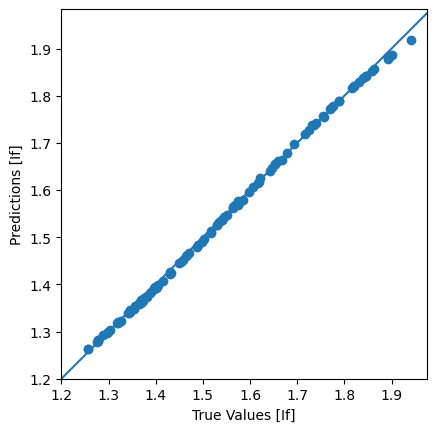

In [165]:
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [If]')
plt.ylabel('Predictions [If]')
plt.axis('equal')
plt.axis('square')
plt.xlim([1.2,plt.xlim()[1]])
plt.ylim([1.2,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

test_predictions_df = pd.DataFrame(test_predictions, columns=['If Prediction'])
test_predictions_df

results = pd.concat([test_df, test_labels, test_predictions_df], axis=1, join='inner')
display(results)

error = test_predictions - test_labels
px.histogram(x=error).show()
